# 0. IMPORT LIBRARIES

In [1]:
globals().clear
import time
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from datetime import datetime
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. LOAD AND FORMAT DATA

In [3]:
#Load Dataset
df = pd.read_csv('/Users/stevenwhang/Capstone/Datasets/df.csv')
DATETIME = df.DATETIME
df.shape

(10843, 75)

In [4]:
# Load dataset
path = '/content/drive/MyDrive/CapstoneProject/code/02. Machine Learning/data/'
file = 'df.csv'
df = pd.read_csv(path+file)
DATETIME = df.DATETIME
df.shape

(10758, 75)

# 2. CREATE THE MODEL: Train 60 days and predict 1 day

In [4]:
import time
file_name = 'SVR.60d.1d'
step_rows  = 1*22  #22*20 #110    (01 day)
total_rows = 10758         #      (24 months)
train_rows = 60*22 #420*22 #9240. (03 months)

scale_X = MinMaxScaler()
model = SVR(kernel = 'rbf')

result = pd.DataFrame(columns = ['DATETIME', 'ACTUAL', 'PREDICTED', 'DIFFERENCE', 'TRAIN_DURATION'])

for i in range(0, total_rows - train_rows, step_rows):

  st = time.time()
  # 1. Obtain X and y
  train, test = df.iloc[i:train_rows+i, 1:], df.iloc[train_rows+i:train_rows+i+step_rows, 1:]
  X_train, y_train  = train.iloc[:,:-1], train.iloc[:,-1]
  X_test , y_test   = test.iloc[:,:-1] , test.iloc[:,-1]

  # 2. Scale X
  X_train = scale_X.fit_transform(X_train)
  X_test = scale_X.transform(X_test)
  
  # 3. Fit and Predict 
  model.fit(X_train,y_train)
  y_hat = model.predict(X_test)
  et = time.time()

  # 4. Save data with prediction
  fecha = DATETIME.iloc[train_rows+i:train_rows+i+step_rows]
  datos = {'DATETIME': fecha.ravel(), 'ACTUAL': y_test.ravel(), 'PREDICTED': y_hat.ravel(), 'DIFFERENCE': abs(y_hat.ravel()-y_test.ravel()), 'TRAIN_DURATION': np.full(y_hat.ravel().shape[0], et-st)}
  data = pd.DataFrame(data = datos)
  result = result.append(data)

  print("Count Down: ", math.trunc((total_rows-train_rows-i)/step_rows))
  #print(data.head())

Count Down:  429
Count Down:  428
Count Down:  427
Count Down:  426
Count Down:  425
Count Down:  424
Count Down:  423
Count Down:  422
Count Down:  421
Count Down:  420
Count Down:  419
Count Down:  418
Count Down:  417
Count Down:  416
Count Down:  415
Count Down:  414
Count Down:  413
Count Down:  412
Count Down:  411
Count Down:  410
Count Down:  409
Count Down:  408
Count Down:  407
Count Down:  406
Count Down:  405
Count Down:  404
Count Down:  403
Count Down:  402
Count Down:  401
Count Down:  400
Count Down:  399
Count Down:  398
Count Down:  397
Count Down:  396
Count Down:  395
Count Down:  394
Count Down:  393
Count Down:  392
Count Down:  391
Count Down:  390
Count Down:  389
Count Down:  388
Count Down:  387
Count Down:  386
Count Down:  385
Count Down:  384
Count Down:  383
Count Down:  382
Count Down:  381
Count Down:  380
Count Down:  379
Count Down:  378
Count Down:  377
Count Down:  376
Count Down:  375
Count Down:  374
Count Down:  373
Count Down:  372
Count Down:  3

# 3. CREATE DATASET FOR METRICS AND GRAPH

In [5]:
result = result.reset_index(drop=True)
result.dropna(inplace = True)
result['DATETIME'] = pd.to_datetime(result['DATETIME'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
result['DATE']     = result.DATETIME.dt.date

# 4. CREATE THE GRAPH

<ipython-input-6-cfbf284bbdde>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  graph = pd.DataFrame(result.groupby('DATE')['PREDICTED','ACTUAL', 'DIFFERENCE'].mean())


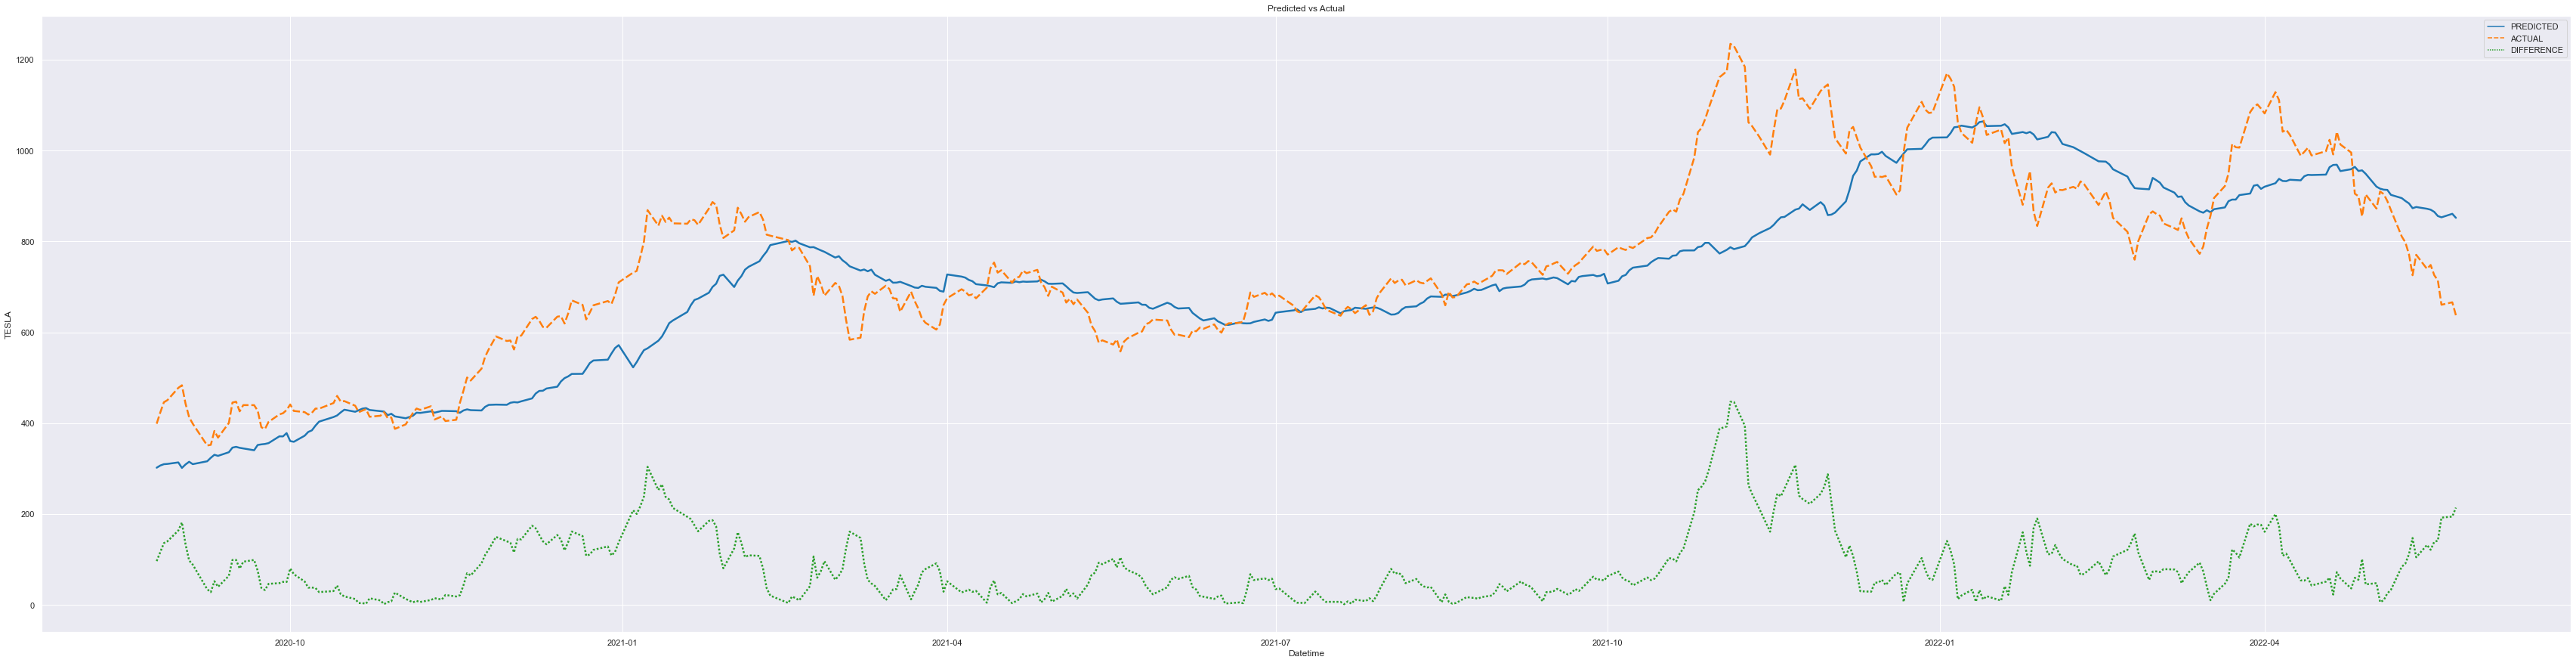

In [6]:
graph = pd.DataFrame(result.groupby('DATE')['PREDICTED','ACTUAL', 'DIFFERENCE'].mean())
plt.figure(figsize=(60,15))
linep = sns.lineplot(data = graph, palette="tab10", linewidth=2.5)
linep.set(xlabel='Datetime', ylabel='TESLA', title='Predicted vs Actual')
plt.show()

# 5. CALCULATE METRICS

In [7]:
#Check the overall RMSE value
rmse = np.sqrt(mean_squared_error(result['ACTUAL'], result['PREDICTED']))
rmse

112.29521511592277

In [8]:
#Check the overall MAPE value
mape = mean_absolute_percentage_error(result['ACTUAL'], result['PREDICTED'])
mape 

0.10792589668464121

In [9]:
#Check the mean difference
average = graph.DIFFERENCE.mean()
average

83.31140860222784

In [10]:
#Check the Mean Train Time
time = result.TRAIN_DURATION.mean()
time # Seconds

0.09716987665438707

In [11]:
metrics = {'RMSE': [rmse], 'MAPE': [mape], 'MAE': [average], 'MTT': [time]}
metrics = pd.DataFrame(data = metrics, index = ['SVR'])

In [13]:
#Writting files
path = '/content/drive/MyDrive/CapstoneProject/code/02. Machine Learning/output/'
graph.to_csv(path+file_name+'-GRAPH.csv', index=True)
result.to_csv(path+file_name+'-RESULT.csv', index=True)
metrics.to_csv(path+file_name+'-METRICS.csv', index=True)